In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d s076923/pytorch-transformer


Dataset URL: https://www.kaggle.com/datasets/s076923/pytorch-transformer
License(s): other
 99% 906M/916M [00:10<00:00, 72.0MB/s]
100% 916M/916M [00:10<00:00, 94.4MB/s]


In [3]:
import shutil

shutil.unpack_archive(
    filename="pytorch-transformer.zip",
    extract_dir="./", # 현재 경로는 pytorchtrf로 가정합니다.
    format="zip"
)


In [4]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder


hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[1.0/255.0, 1.0/255.0, 1.0/255.0]
            )
        ]
    )
}

train_dataset = ImageFolder("/content/datasets/pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("/content/datasets/pet/test", transform=hyperparams["transform"])
#ImageFolder 클래스는 해당 위치에 있는 폴더에 순서대로 0부터 레이블을 부여한 후에 해당 레이블 디렉토리 안에 이미지들에 레이블을 부여
#총 길이는 데이터의 갯수이며, 그안에 이미지와 레이블이 순서대로 있다.
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)

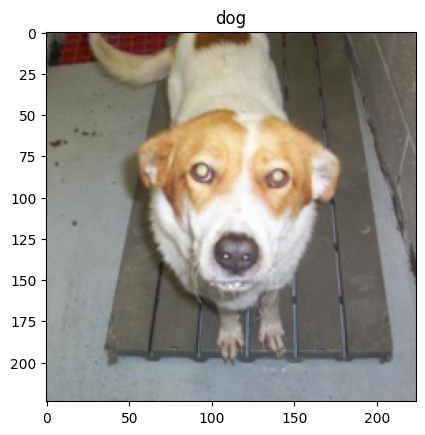

In [5]:
import numpy as np
from matplotlib import pyplot as plt


mean=[0.48235, 0.45882, 0.40784]
std=[1.0/255.0, 1.0/255.0, 1.0/255.0]

images, labels = next(iter(train_dataloader))
for image, label in zip(images, labels):
    image = image.numpy().transpose((1, 2, 0)) #텐서의 형태는 (채널, 높이, 너비) PIL이미지는 (높이, 너비, 채널)
    image = ((std * image + mean) * 255).astype(np.uint8) #정규화한 데이터 원본으로 복원

    plt.imshow(image)
    plt.title(train_dataset.classes[int(label)])
    plt.show()
    break

In [19]:
model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")
model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])

In [21]:
for epoch in range(hyperparams["epochs"]):
    cost = 0.0

    for images, classes in train_dataloader: #classes는 label과 같은 뜻
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        loss = criterion(output, classes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss

    cost = cost / len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

Epoch :    1, Cost : 0.294
Epoch :    2, Cost : 0.090
Epoch :    3, Cost : 0.061
Epoch :    4, Cost : 0.041
Epoch :    5, Cost : 0.028


In [22]:
with torch.no_grad():
    model.eval()

    accuracy = 0.0
    for images, classes in test_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=-1)
        outputs_classes = torch.argmax(probs, dim=-1)

        accuracy += int(torch.eq(classes, outputs_classes).sum())

    print(f"acc@1 : {accuracy / (len(test_dataloader) * hyperparams['batch_size']) * 100:.2f}%")

acc@1 : 97.18%
